In [1]:
from keras.models import load_model
from model import *
from deepseg_gm import *
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import tensorflow as tf
from keras import Model
import imgaug as ia
import imgaug.augmenters as iaa
import math
import random

In [2]:
'''
Normalize volume to mean ~= 0 and std ~= 1
@input: volume to be normalized
@return: normalized volume
'''
def vol_norm(volume):
    """This method will enable the function call for the
        class object.

        :param volume: the volume to be normalized.
        """
    volume_mean = volume.mean()
    volume_std = volume.std()

    volume -= volume_mean
    volume /= volume_std

    return volume

In [3]:
'''
Reshape the matrix and fix the dimensionality
@input 3D array
@output: concatenated array
'''
def shape_and_norm(arr, norm = True):
    arr_sampled = []
    for i in range(arr.shape[2]):
        if norm:
            arr_sampled.append(vol_norm(np.reshape(arr[:,:,i], (1, 256, 256))))
        else:
            # Just resample no norm 
            arr_sampled.append(np.reshape(arr[:,:,i], (1, 256, 256)))
    return np.concatenate(arr_sampled, axis=0)

In [4]:
'''
Reshape a single slice to (1, 256, 256) and vice versa
@input: 2D array
@return: reshaped array
'''
def reshape_single_slice(arr, inverse = False):
    if not inverse:
        return np.reshape(arr, (1, 256, 256))
    else:
        return np.reshape(arr, (256, 256))

In [5]:
bmodel = create_model(32)
opt = Adam(lr=0.001)
bmodel.compile(optimizer=opt,
                loss=dice_coef_loss,
                metrics=['accuracy', dice_coef])
bmodel.load_weights('challenge_model.hdf5')

D:\noSpace\Anaconda3\envs\py38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
bmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

### Load in the data and do some testing

In [6]:
#Load in the data
train_data = shape_and_norm(np.load('../data/train_data.npy'))
train_targets = shape_and_norm(np.load('../data/train_targets.npy'), False)
val_data = shape_and_norm(np.load('../data/val_data.npy'))
val_targets = shape_and_norm(np.load('../data/val_targets.npy'), False)
test_data = shape_and_norm(np.load('../data/test_data.npy'))
test_targets = shape_and_norm(np.load('../data/test_targets.npy'), False)
sct_targets = shape_and_norm(np.load('../data/sct_targets.npy'), False)

### Try some training

In [304]:
history = Model.fit(bmodel, train_data, train_targets, batch_size=BATCH_SIZE, epochs=15, validation_data=(val_data, val_targets), validation_batch_size=BATCH_SIZE)

Epoch 1/15
49/49 [==============================] - 266s 5s/step - loss: -0.8237 - accuracy: 0.9991 - dice_coef: 0.8237 - val_loss: -0.8463 - val_accuracy: 0.9993 - val_dice_coef: 0.8469
Epoch 2/15
49/49 [==============================] - 263s 5s/step - loss: -0.8420 - accuracy: 0.9991 - dice_coef: 0.8420 - val_loss: -0.8510 - val_accuracy: 0.9993 - val_dice_coef: 0.8516
Epoch 3/15
49/49 [==============================] - 262s 5s/step - loss: -0.8586 - accuracy: 0.9992 - dice_coef: 0.8586 - val_loss: -0.8642 - val_accuracy: 0.9994 - val_dice_coef: 0.8647
Epoch 4/15
49/49 [==============================] - 283s 6s/step - loss: -0.8609 - accuracy: 0.9993 - dice_coef: 0.8609 - val_loss: -0.8676 - val_accuracy: 0.9994 - val_dice_coef: 0.8679
Epoch 5/15
49/49 [==============================] - 293s 6s/step - loss: -0.8684 - accuracy: 0.9993 - dice_coef: 0.8684 - val_loss: -0.8698 - val_accuracy: 0.9994 - val_dice_coef: 0.8701
Epoch 6/15
49/49 [==============================] - 2652s 55s/ste

In [305]:
(loss, accuracy, dsc) = Model.evaluate(bmodel, test_data, test_targets, verbose=1)

7/7 [==============================] - 39s 5s/step - loss: -0.8989 - accuracy: 0.9994 - dice_coef: 0.9042


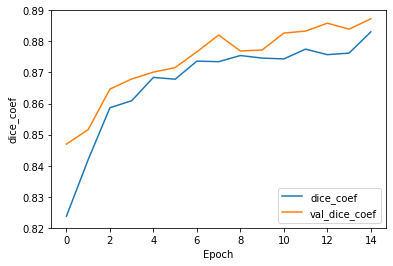

In [310]:
plt.plot(history.history['dice_coef'], label='dice_coef')
plt.plot(history.history['val_dice_coef'], label = 'val_dice_coef')
plt.xlabel('Epoch')
plt.ylabel('dice_coef')
plt.ylim([0.82, 0.89])
plt.legend(loc='lower right')

In [7]:
#Calculate DSC
all_preds = Model.predict(bmodel, test_data)

# Reshape and threshold predictions
all_preds = threshold_predictions(np.reshape(all_preds, (196, 256, 256)))

dsc_scores = []
for i in range(all_preds.shape[0]):
    dsc_scores.append(dice_coef(test_targets[i,:,:].astype('float64'), all_preds[i, :, :].astype('float64')))

print('{:.4f}±{:.4f}'.format(np.mean(dsc_scores),np.std(dsc_scores)))

0.7934±0.2525


### Compare SCT_output with test_targets to get dsc

In [7]:
#Calculate DSC
sct_dsc_scores = []
for i in range(sct_targets.shape[0]):
    sct_dsc_scores.append(dice_coef(test_targets[i,:,:].astype('float64'), sct_targets[i, :, :].astype('float64')))

print('{:.4f}±{:.4f}'.format(np.mean(sct_dsc_scores),np.std(sct_dsc_scores)))

0.8736±0.1570


In [312]:
# Save model
bmodel.save_weights('trained_15_epoch_no_augmentation.h5')

## Try data augmentatiton

### Training Data Augmentation

In [10]:
train_data_aug = [train_data]
train_targets_aug = [train_targets]
multiplier = 32
for i in range(np.shape(train_data)[0]):
    ia.seed(1)

    # Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
    # e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    # Example batch of images.
    # The array has shape (32, 64, 64, 3) and dtype uint8.
    images = np.array(
        [train_data[i].astype('float32') for _ in range(multiplier)],
    )

    images_seg = np.array(
        [np.reshape(train_targets[i].astype('uint8'), (256, 256, 1)) for _ in range(multiplier)]
    )

    seq = iaa.Sequential([
        # iaa.Fliplr(0.5), # horizontal flips
        iaa.Crop(percent=(0, 0.1)), # random crops
        # # Small gaussian blur with random sigma between 0 and 0.5.
        # # But we only blur about 50% of all images.
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        # Strengthen or weaken the contrast in each image.
        iaa.LinearContrast((0.75, 1.5)),
        # Add gaussian noise.
        # For 50% of all images, we sample the noise once per pixel.
        # For the other 50% of all images, we sample the noise per pixel AND
        # channel. This can change the color (not only brightness) of the
        # pixels.
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*5)),
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        # Apply affine transformations to each image.
        # Scale/zoom them, translate/move them, rotate them and shear them.
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        )
    ], random_order=True) # apply augmenters in random order

    images_aug, images_seg_aug = seq(images=images, segmentation_maps=images_seg)
    images_aug = images_aug.astype('double')
    train_data_aug.append(images_aug)
    train_targets_aug.append(np.reshape(images_seg_aug, (multiplier, 256, 256)))

In [11]:
train_data_aug = np.concatenate(train_data_aug, axis=0)
train_targets_aug = np.concatenate(train_targets_aug, axis=0)

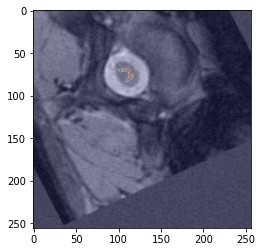

In [74]:
slice = random.randint(0, np.shape(train_data_aug)[0])
plt.imshow(train_data_aug[slice].astype('double'), cmap='gray')
plt.imshow(train_targets_aug[slice], cmap='jet', alpha=0.2)

In [60]:
np.save('train_data_aug.npy', train_data_aug.astype('float16'))
np.save('train_targets_aug.npy', train_targets_aug.astype('uint8'))

### Validation Data 

In [44]:
val_data_aug = [val_data]
val_targets_aug = [val_targets]
multiplier = 32
for i in range(np.shape(val_data)[0]):
    ia.seed(1)

    # Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
    # e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    # Example batch of images.
    # The array has shape (32, 64, 64, 3) and dtype uint8.
    images = np.array(
        [val_data[i].astype('float32') for _ in range(multiplier)],
    )

    images_seg = np.array(
        [np.reshape(val_targets[i].astype('uint8'), (256, 256, 1)) for _ in range(multiplier)]
    )

    seq = iaa.Sequential([
        # iaa.Fliplr(0.5), # horizontal flips
        iaa.Crop(percent=(0, 0.1)), # random crops
        # # Small gaussian blur with random sigma between 0 and 0.5.
        # # But we only blur about 50% of all images.
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        # Strengthen or weaken the contrast in each image.
        iaa.LinearContrast((0.75, 1.5)),
        # Add gaussian noise.
        # For 50% of all images, we sample the noise once per pixel.
        # For the other 50% of all images, we sample the noise per pixel AND
        # channel. This can change the color (not only brightness) of the
        # pixels.
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*5)),
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        # Apply affine transformations to each image.
        # Scale/zoom them, translate/move them, rotate them and shear them.
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        )
    ], random_order=True) # apply augmenters in random order

    images_aug, images_seg_aug = seq(images=images, segmentation_maps=images_seg)
    images_aug = images_aug.astype('double')
    val_data_aug.append(images_aug)
    val_targets_aug.append(np.reshape(images_seg_aug, (multiplier, 256, 256)))

In [45]:
val_data_aug = np.concatenate(val_data_aug, axis=0)
val_targets_aug = np.concatenate(val_targets_aug, axis=0)

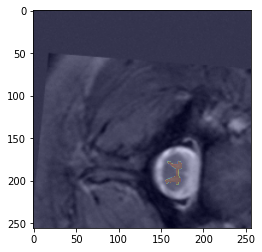

In [55]:
slice = random.randint(0, np.shape(val_data_aug)[0])
plt.imshow(val_data_aug[slice], cmap='gray')
plt.imshow(val_targets_aug[slice], cmap='jet', alpha=0.2)

In [75]:
np.save('val_data_aug.npy', val_data_aug.astype('float16'))
np.save('val_targets_aug.npy', val_targets_aug.astype('uint8'))

In [171]:
def vol_sub_norm(volume):
    """This method will enable the function call for the
        class object.

        :param volume: the volume to be normalized.
        """
    volume_mean = volume[np.nonzero(volume)].mean()
    volume_std = volume[np.nonzero(volume)].std()

    volume[np.nonzero(volume)] -= volume_mean
    volume[np.nonzero(volume)] /= volume_std

    return volume

def arr_norm(arr):
    arr_sampled = []
    for i in range(np.shape(arr)[0]):
        arr_sub = np.reshape(arr[i, :, :], (1, 256, 256))
        arr_sub_norm = np.reshape(vol_sub_norm(arr_sub), (1, 256, 256))
        arr_sampled.append(arr_sub_norm)
    return np.concatenate(arr_sampled, axis=0)

In [160]:
train_data_aug = np.load('../data/train_data_aug.npy')

In [172]:
train_data_aug_norm = arr_norm(train_data_aug)

C:\Users\Captain\AppData\Local\Temp/ipykernel_30220/1873502753.py:7: RuntimeWarning: Mean of empty slice.
  volume_mean = volume[np.nonzero(volume)].mean()
D:\noSpace\Anaconda3\envs\py38\lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: invalid value encountered in true_divide
  ret = arr.dtype.type(ret / rcount)
D:\noSpace\Anaconda3\envs\py38\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\noSpace\Anaconda3\envs\py38\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
D:\noSpace\Anaconda3\envs\py38\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [152]:
np.shape(train_data_aug_norm)

(940834815,)

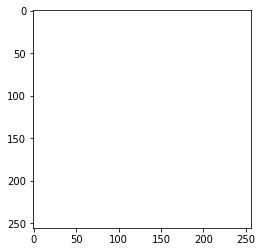

In [159]:
plt.imshow(train_data_aug[8].astype('double'), cmap='gray')